# Importing Library

In [1]:
!pip install -q polyglot
!pip install -q pycld2
!pip install -q pyicu


In [2]:
import pandas as pd
import numpy as np
import nltk
import string
import re
import matplotlib.pyplot as plt
import seaborn as sns
from polyglot.detect import Detector
import icu
from string import punctuation
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from xgboost import XGBClassifier

import warnings

warnings.filterwarnings("ignore")
nltk.download('popular')

ImportError: dlopen(/opt/homebrew/lib/python3.10/site-packages/icu/_icu_.cpython-310-darwin.so, 0x0002): symbol not found in flat namespace '__ZN6icu_5810DateFormat14createInstanceEv'

# Load Data

In [4]:
df = pd.read_csv('./input/quotes-from-goodread/all_quotes.csv')
df.sample(5)

,Unnamed: 0,Quote,Author,Main Tag,Other Tags
4990,4990,"“She cannot possibly be dead, people do not ju...","― John Green, Looking for Alaska",death,[' death']
24219,24219,“I like the imp / in impossibility ”,― Pierre Joris,poetry,[' poetry']
18725,18725,“A stagecoach passed by on the road and went on;,And the road didn’t become more beautiful or e...,truth,"[' forgetting, god, human-nature, it-is-what-i..."
16688,16688,“Sometimes failure is the beginning of success”,"― Astrid Scholte, Four Dead Queens",success,"[' failure, four-dead-queens, inspirational, k..."
5549,5549,“I don't worry about how other people perceive...,― Cheyanne Ratnam,success,"[' energy, gossip, growth, inner-voice, inspir..."


# EDA

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  30000 non-null  int64 
 1   Quote       30000 non-null  object
 2   Author      28401 non-null  object
 3   Main Tag    30000 non-null  object
 4   Other Tags  30000 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.1+ MB


In [8]:
df.isnull().sum()

Unnamed: 0       0
Quote            0
Author        1599
Main Tag         0
Other Tags       0
dtype: int64

In [9]:
df['Main Tag'].value_counts()

happiness      3000
death          3000
truth          3000
poetry         3000
inspiration    3000
romance        3000
love           3000
science        3000
success        3000
time           3000
Name: Main Tag, dtype: int64

<AxesSubplot:>

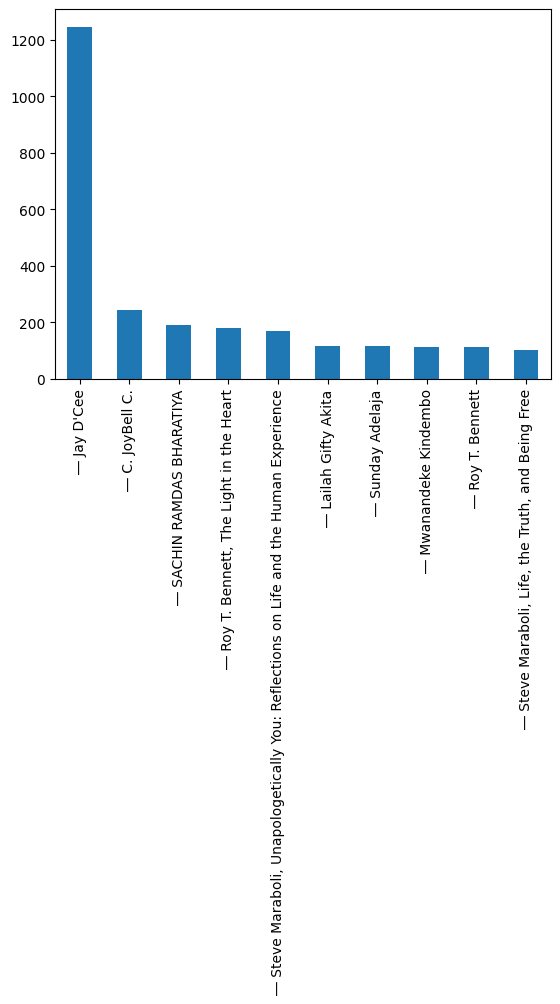

In [10]:
df['Author'].value_counts().head(10).plot(kind='bar')

In [11]:
df['Quote'] = df['Quote'].apply(lambda x: re.sub("[\“\”]", "", x))
df['Other Tags'] = df['Other Tags'].apply(lambda x: re.sub("[\'\[\]]", "", x))

<AxesSubplot:>

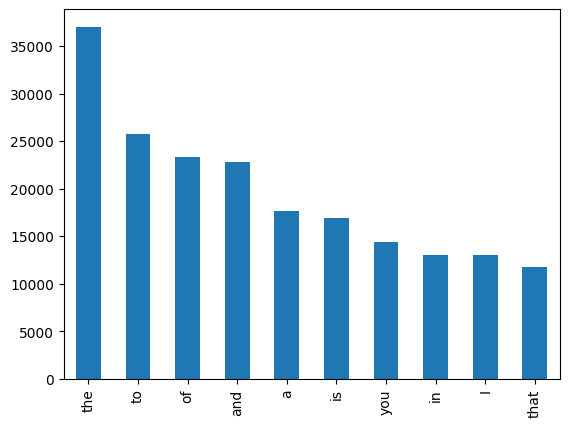

In [12]:
# Count Quote Word Freq
quote_count = pd.Series(' '.join(df['Quote']).split()).value_counts()
quote_count.head(10).plot(kind='bar')

<AxesSubplot:>

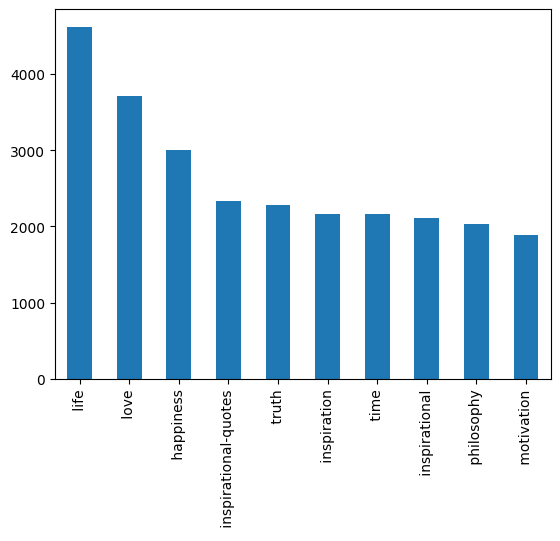

In [13]:
# Count Other Tag Word Freq
othertag_count = pd.Series(' '.join(df['Other Tags']).split(',')).value_counts()
othertag_count.head(10).plot(kind='bar')

In [14]:
# Count Number of Words
df['word_count'] = df['Quote'].apply(lambda x: len(str(x).split(" ")))
df.sort_values('word_count', ascending=False).head()

,Unnamed: 0,Quote,Author,Main Tag,Other Tags,word_count
14911,14911,"It was the general opinion of ancient nations,...",NaN,science,"advantage, artifice, constitution, discovery,...",615
21189,21189,"It was the general opinion of ancient nations,...",NaN,happiness,"advantage, artifice, constitution, discovery,...",615
27033,27033,"My dearest friend Abigail, These probably coul...",NaN,happiness,"brokenness, death-is-the-road-to-awe, death-n...",569
11156,11156,"Not a single nation, he went on, as though rea...","Stavrogin observed cautiously... ""The very fac...",science,"god, nationalism, nations, science, socialism",543
11967,11967,4. Religion. Your reason is now mature enough ...,NaN,science,"astronomy-nerd, book-of-joshua, contradiction...",509


In [15]:
# Count Number Of Character
df['char_count'] = df['Quote'].str.len() ## this also includes spaces
df.sort_values('char_count', ascending=False).head(5)

,Unnamed: 0,Quote,Author,Main Tag,Other Tags,word_count,char_count
21189,21189,"It was the general opinion of ancient nations,...",NaN,happiness,"advantage, artifice, constitution, discovery,...",615,3807
14911,14911,"It was the general opinion of ancient nations,...",NaN,science,"advantage, artifice, constitution, discovery,...",615,3807
27654,27654,We have increased our population to the level ...,NaN,science,"crisis, globalization, humanity, pandemics, s...",499,3076
11156,11156,"Not a single nation, he went on, as though rea...","Stavrogin observed cautiously... ""The very fac...",science,"god, nationalism, nations, science, socialism",543,2998
27033,27033,"My dearest friend Abigail, These probably coul...",NaN,happiness,"brokenness, death-is-the-road-to-awe, death-n...",569,2941


In [16]:
# Count of Duplicated quote
df[df.duplicated('Quote')==True].groupby('Main Tag')['Quote'].count()

Main Tag
death          190
happiness      508
inspiration    140
love           293
poetry         210
romance        184
science         79
success        164
time           402
truth          180
Name: Quote, dtype: int64

In [17]:
# Detect Text Language
langs = []
for text in df['Quote']:
    try:
        lang = Detector(text).language.code
        langs.append(lang)
    except:
        lang = 'NaN'
        langs.append(lang)
df['lang'] = langs

In [18]:
df['lang'].value_counts().head(10)

NaN    30000
Name: lang, dtype: int64

# Preprocessing

In [21]:
# I will only use Eng Quote
df_eng = df[df['lang']=='en']
print(df_eng.shape)
df_eng['Main Tag'].value_counts()

(0, 8)


Series([], Name: Main Tag, dtype: int64)

## Lower Text

In [20]:
df_eng['CleanQuote'] = df_eng['Quote'].apply(lambda x: x.lower())
df_eng['CleanQuote'].sample(2)

ValueError: a must be greater than 0 unless no samples are taken

## Remove Punc & Stopword

In [18]:
stop_nltk = stopwords.words("english")

def drop_stop(input_tokens):
    rempunc = re.sub(r'[^\w\s]','',input_tokens)
    remstopword = " ".join([word for word in str(rempunc).split() if word not in stop_nltk])
    return remstopword

df_eng['CleanQuote'] = df_eng['CleanQuote'].apply(lambda x: drop_stop(x))
df_eng['CleanQuote'].sample(2)

4112    doesnt always take army save world sometimes t...
7212    despite known almost year lot things still did...
Name: CleanQuote, dtype: object

## Lemmatization

In [19]:
lemmatizer = WordNetLemmatizer()
wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}
def lemmatize_words(text):
    pos_tagged_text = nltk.pos_tag(text.split())
    return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])

df_eng["CleanQuote"] = df_eng["CleanQuote"].apply(lambda x: lemmatize_words(x))
df_eng['CleanQuote'].sample(2)

29472    give right inspiration mind always beat muscle...
629      write inspire may fairly decent poet youll nev...
Name: CleanQuote, dtype: object

## Specify Feature and Target

In [20]:
X = df_eng['CleanQuote']
Y = df_eng['Main Tag']

## Split Data to Train and Test

In [21]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=48, stratify=Y)

In [22]:
print(f"X_train : {X_train.shape}\nX_test : {X_test.shape}")

X_train : (23242,)
X_test : (5811,)


## Extracting Feature

In [23]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

# Modelling

## 1. Create Naive Baiyes Pipeline

In [24]:
NB = MultinomialNB().fit(X_train_tfidf, Y_train)

In [25]:
pipeline_nb = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('NB', MultinomialNB()),
                    ])

model_nb = pipeline_nb.fit(X_train, Y_train)

In [26]:
predict_nb = model_nb.predict(X_test)

In [27]:
print(classification_report(predict_nb, Y_test))

              precision    recall  f1-score   support

       death       0.59      0.48      0.53       726
   happiness       0.44      0.47      0.46       554
 inspiration       0.23      0.38      0.29       345
        love       0.59      0.31      0.41      1119
      poetry       0.24      0.59      0.34       227
     romance       0.39      0.45      0.42       499
     science       0.71      0.64      0.67       642
     success       0.59      0.55      0.57       644
        time       0.43      0.50      0.46       504
       truth       0.46      0.50      0.48       551

    accuracy                           0.47      5811
   macro avg       0.47      0.49      0.46      5811
weighted avg       0.51      0.47      0.48      5811



## 2. Create SGDClassifier Pipeline

In [28]:
pipeline_sgd = Pipeline([('vect', CountVectorizer()),
                         ('tfidf', TfidfTransformer()),
                         ('clf-svm', SGDClassifier(loss='hinge', penalty='l2',
                          alpha=1e-3, random_state=42)),
                        ])

model_sgd = pipeline_sgd.fit(X_train, Y_train)

In [29]:
predict_sgd = model_sgd.predict(X_test)

In [30]:
print(classification_report(predict_sgd, Y_test))

              precision    recall  f1-score   support

       death       0.63      0.55      0.59       680
   happiness       0.50      0.53      0.51       554
 inspiration       0.21      0.38      0.27       310
        love       0.47      0.43      0.45       643
      poetry       0.44      0.47      0.45       534
     romance       0.33      0.46      0.39       418
     science       0.70      0.57      0.63       698
     success       0.59      0.53      0.56       652
        time       0.59      0.47      0.52       729
       truth       0.54      0.54      0.54       593

    accuracy                           0.50      5811
   macro avg       0.50      0.49      0.49      5811
weighted avg       0.53      0.50      0.51      5811



## 3. Create Random Forest Classifier Pipeline

In [31]:
pipeline_rf = Pipeline([('vect', CountVectorizer()),
                         ('tfidf', TfidfTransformer()),
                         ('rf', RandomForestClassifier()),
                        ])

model_rf = pipeline_rf.fit(X_train, Y_train)

In [32]:
predict_rf = model_rf.predict(X_test)

In [33]:
print(classification_report(predict_rf, Y_test))

              precision    recall  f1-score   support

       death       0.54      0.61      0.57       526
   happiness       0.44      0.51      0.47       513
 inspiration       0.27      0.30      0.28       496
        love       0.43      0.39      0.41       648
      poetry       0.61      0.37      0.46       935
     romance       0.37      0.37      0.37       574
     science       0.60      0.71      0.65       490
     success       0.53      0.55      0.54       560
        time       0.49      0.47      0.48       604
       truth       0.44      0.56      0.50       465

    accuracy                           0.47      5811
   macro avg       0.47      0.48      0.47      5811
weighted avg       0.48      0.47      0.47      5811



## 4. Create XGBoost Classifier Pipeline

In [34]:
pipeline_xgb = Pipeline([('vect', CountVectorizer()),
                         ('tfidf', TfidfTransformer()),
                         ('xgb', XGBClassifier()),
                        ])

model_xgb = pipeline_xgb.fit(X_train, Y_train)

[07:18:04] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [35]:
predict_xgb = model_xgb.predict(X_test)

In [36]:
print(classification_report(predict_xgb, Y_test))

              precision    recall  f1-score   support

       death       0.57      0.65      0.61       519
   happiness       0.45      0.56      0.50       473
 inspiration       0.31      0.30      0.31       586
        love       0.47      0.43      0.45       646
      poetry       0.68      0.38      0.49      1010
     romance       0.37      0.42      0.39       503
     science       0.61      0.77      0.68       460
     success       0.52      0.55      0.54       555
        time       0.54      0.53      0.53       585
       truth       0.47      0.59      0.52       474

    accuracy                           0.50      5811
   macro avg       0.50      0.52      0.50      5811
weighted avg       0.51      0.50      0.50      5811



In [39]:
model = predict_xgb

import pickle

# save the model to disk
filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))
